<a href="https://colab.research.google.com/github/Nachi2006/MLREPO/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

# Set seaborn style
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

# Download Titanic dataset
titanic_url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(titanic_url)




=== Exploratory Data Analysis ===

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Basic Statistics:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0

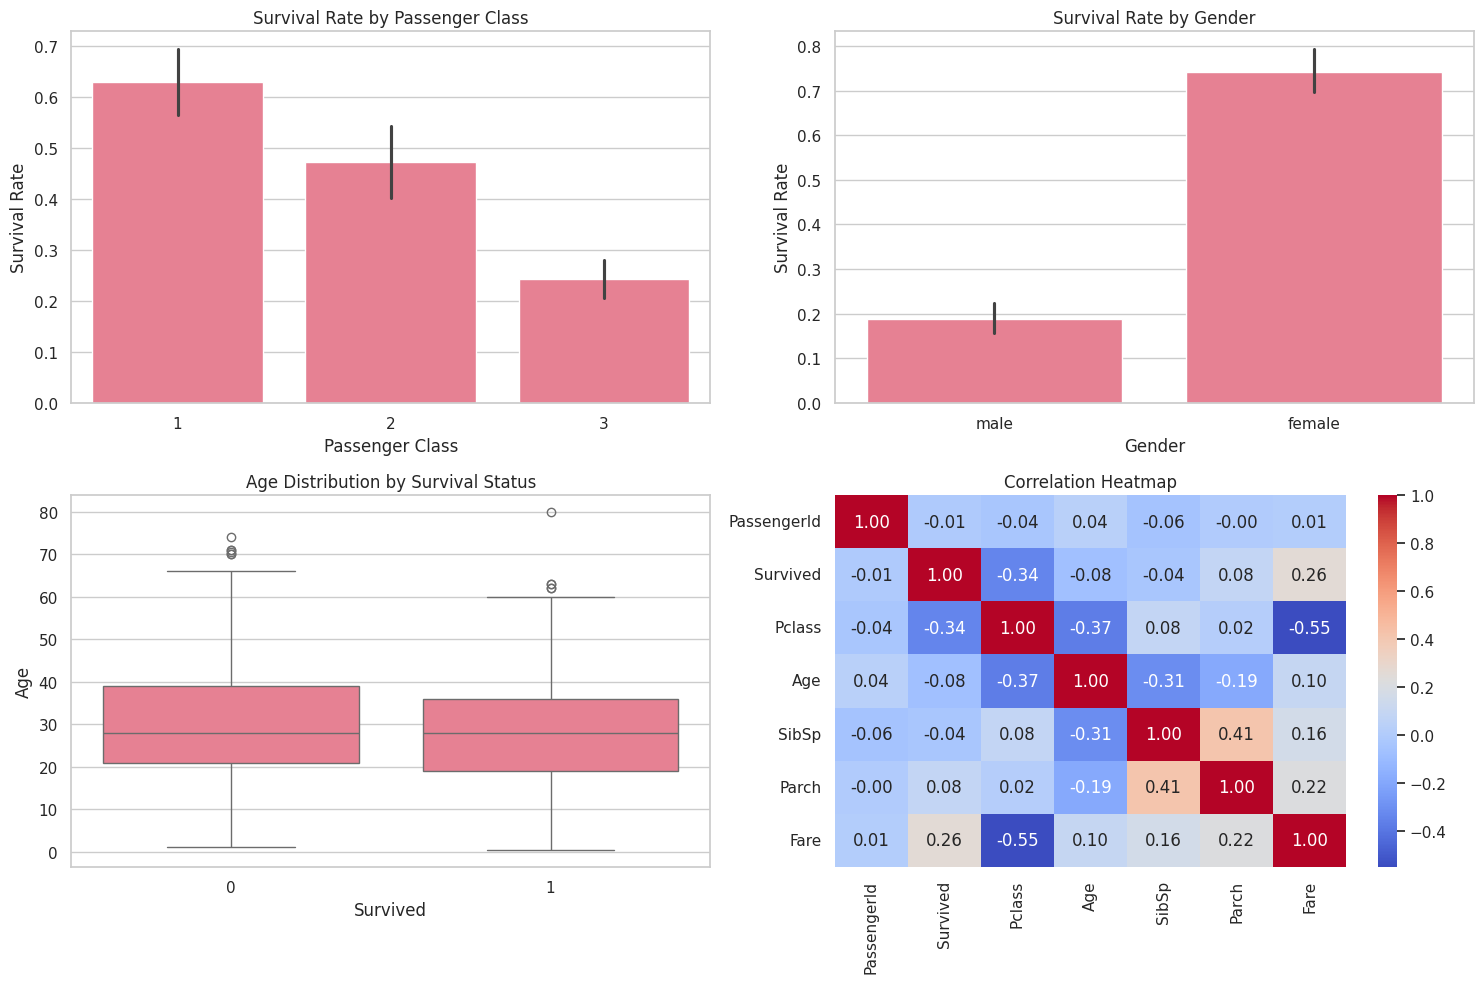

In [9]:
# Task 1.1: Exploratory Data Analysis (EDA)
print('\n=== Exploratory Data Analysis ===\n')

# Display basic information about the dataset
print('Dataset Information:')
print(df.info())
print('\nBasic Statistics:')
print(df.describe())
print('\nMissing Values:')
print(df.isnull().sum())

# Create a figure with subplots for EDA visualizations
plt.figure(figsize=(15, 10))

# Survival Rate by Passenger Class
plt.subplot(2, 2, 1)
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')

# Survival Rate by Gender
plt.subplot(2, 2, 2)
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Survival Rate')

# Age Distribution by Survival
plt.subplot(2, 2, 3)
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Age Distribution by Survival Status')
plt.xlabel('Survived')
plt.ylabel('Age')

# Correlation Heatmap
plt.subplot(2, 2, 4)
numeric_cols = df.select_dtypes(include=[np.number]).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()




=== Enhanced Feature Engineering and Machine Learning ===


Model Comparison:
--------------------------------------------------

Logistic Regression Results:
Best Parameters: {'C': 0.1, 'max_iter': 1000}
Accuracy: 0.804

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179


Random Forest Results:
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.827

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted av

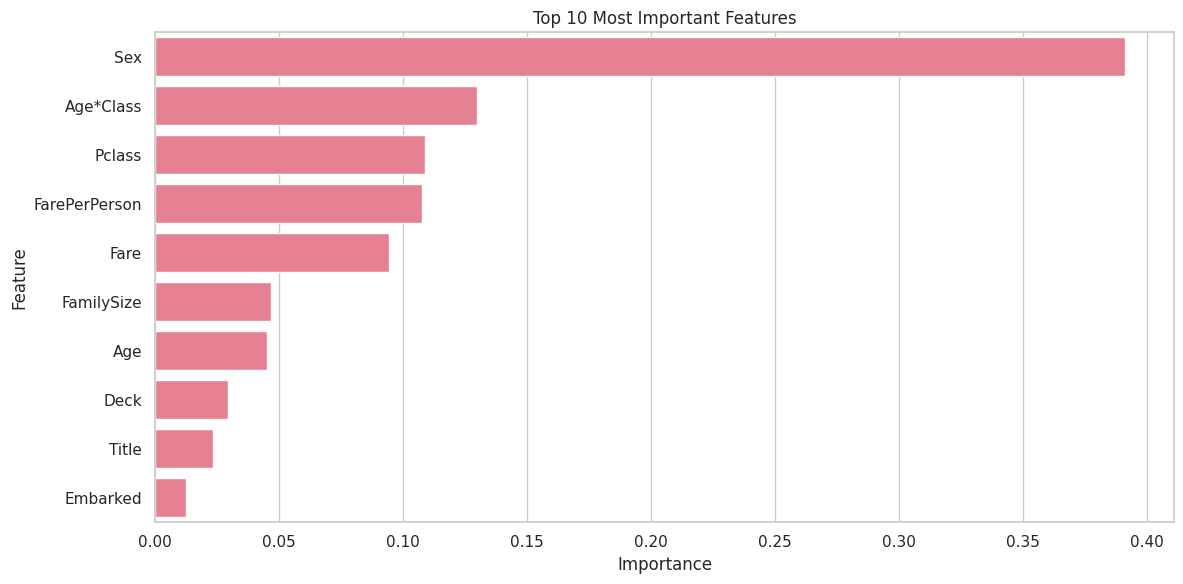

In [10]:
# Task 1.2: Enhanced Feature Engineering and Machine Learning
print('\n=== Enhanced Feature Engineering and Machine Learning ===\n')

def enhance_features(df):
    df_enhanced = df.copy()

    # Extract titles from names
    df_enhanced['Title'] = df_enhanced['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_mapping = {
        'Mr': 'Mr',
        'Miss': 'Miss',
        'Mrs': 'Mrs',
        'Master': 'Master',
        'Dr': 'Rare',
        'Rev': 'Rare',
        'Col': 'Rare',
        'Major': 'Rare',
        'Mlle': 'Miss',
        'Countess': 'Rare',
        'Ms': 'Miss',
        'Lady': 'Rare',
        'Sir': 'Rare',
        'Mme': 'Mrs',
        'Don': 'Rare',
        'Capt': 'Rare',
        'Jonkheer': 'Rare'
    }
    df_enhanced['Title'] = df_enhanced['Title'].map(lambda x: title_mapping.get(x, 'Rare'))

    # Family features
    df_enhanced['FamilySize'] = df_enhanced['SibSp'] + df_enhanced['Parch'] + 1
    df_enhanced['IsAlone'] = (df_enhanced['FamilySize'] == 1).astype(int)

    # Age bands - using cut instead of qcut to avoid duplicate edges
    df_enhanced['Age'] = df_enhanced['Age'].fillna(df_enhanced['Age'].median())
    age_bins = [0, 16, 32, 48, 64, np.inf]
    age_labels = ['Child', 'Young', 'Middle', 'Senior', 'Elderly']
    df_enhanced['AgeBand'] = pd.cut(df_enhanced['Age'], bins=age_bins, labels=age_labels)

    # Fare bands - using cut instead of qcut
    df_enhanced['Fare'] = df_enhanced['Fare'].fillna(df_enhanced['Fare'].median())
    fare_bins = [0, 20, 50, 100, 200, np.inf]
    fare_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    df_enhanced['FareBand'] = pd.cut(df_enhanced['Fare'], bins=fare_bins, labels=fare_labels)

    # Extract deck from cabin
    df_enhanced['Deck'] = df_enhanced['Cabin'].str.extract('([A-Z])', expand=False)

    # Age * Class interaction
    df_enhanced['Age*Class'] = df_enhanced['Age'] * df_enhanced['Pclass']

    # Fare per person
    df_enhanced['FarePerPerson'] = df_enhanced['Fare'] / df_enhanced['FamilySize']

    return df_enhanced

def preprocess_data(df):
    df_processed = df.copy()

    # Handle missing values for numeric columns first
    numeric_features = ['Age', 'Fare']
    numeric_imputer = SimpleImputer(strategy='median')
    df_processed[numeric_features] = numeric_imputer.fit_transform(df_processed[numeric_features])

    # Handle missing values for categorical columns
    df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0], inplace=True)
    df_processed['Deck'] = df_processed['Cabin'].str.extract('([A-Z])', expand=False)
    df_processed['Deck'].fillna('Unknown', inplace=True)

    # Drop unnecessary columns
    df_processed.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

    # Convert categorical variables
    categorical_features = ['Sex', 'Embarked', 'Title', 'AgeBand', 'FareBand', 'Deck']
    for feature in categorical_features:
        if feature in df_processed.columns:
            le = LabelEncoder()
            df_processed[feature] = le.fit_transform(df_processed[feature].astype(str))

    # Final check for any remaining NaN values
    if df_processed.isnull().sum().sum() > 0:
        print("Warning: There are still NaN values in the following columns:")
        print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])
        df_processed = df_processed.fillna(0)

    return df_processed

# Enhance features
df_enhanced = enhance_features(df)

# Preprocess the enhanced dataset
df_processed = preprocess_data(df_enhanced)

# Select features for modeling
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize',
           'IsAlone', 'AgeBand', 'FareBand', 'Deck', 'Age*Class', 'FarePerPerson']

X = df_processed[features]
y = df_processed['Survived']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models with hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'max_iter': [1000]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['rbf', 'linear']
        }
    }
}

# Train and evaluate models
print('\nModel Comparison:')
print('-' * 50)

best_score = 0
best_model_name = None
best_model = None

for name, model_info in models.items():
    # Create and train GridSearchCV
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = grid_search.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print results
    print(f'\n{name} Results:')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Accuracy: {accuracy:.3f}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

    # Update best model if current model is better
    if accuracy > best_score:
        best_score = accuracy
        best_model_name = name
        best_model = grid_search.best_estimator_

print(f'\nBest Model: {best_model_name}')
print(f'Best Accuracy: {best_score:.3f}')

# Feature importance for best model (if it's Random Forest or Gradient Boosting)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print('\nTop 10 Most Important Features:')
    print(feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
